
## Mount Google Drive

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

## Install

### 형태소 분석기 설치


In [26]:
#!java -version
#%pip install PyKomoran
#%pip install konlpy

## Import Library

In [27]:
import os
import pickle

import pandas as pd
import re

from konlpy.tag import Okt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm

## GPU Setting

In [28]:
# %tensorflow_version 2.x
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))


## Hyper_parameters

In [29]:
# Colab
# DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/miso'

# Local
DATA_DIR = '/Users/inseoklee/Desktop/miso/data'
SAVE_DIR = '/Users/inseoklee/Desktop/miso/model/TEST_okt'
LOAD_DIR = '/Users/inseoklee/Desktop/miso/model/TEST_okt'

# MAX_LEN -> 패딩 단계에서 설정
EMBEDDING_DIM = 300
NUM_FILTERS = 256
KERNEL_SIZE = 3
HIDDEN_UNITS = 256
DROP_OUT = 0.5

EPOCHS = 30
VERBOSE = 1
BATCH_SIZE = 512
PATIENCE = 10
VALIDATION_SPLIT=0.1

OUTPUT = 7

## Data Load

In [30]:
df = pd.read_csv(DATA_DIR+'/end_sentiment.csv')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123773 entries, 0 to 123772
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    123773 non-null  object
 1   label   123773 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


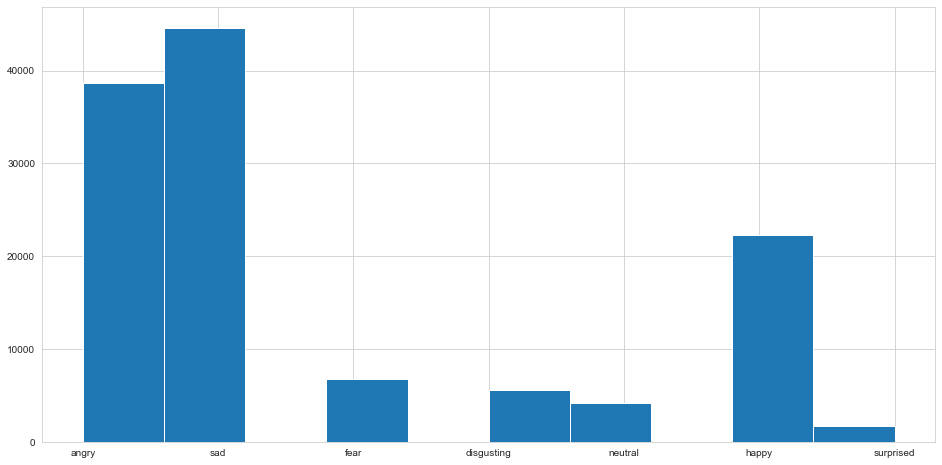

In [32]:
label = df['label']

plt.figure(figsize=(16, 8))
plt.hist(label)
plt.show()

### Train, Test split

In [61]:
X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=34, stratify=y
)

In [62]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('\nX_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (99018,)
y_train shape:  (99018,)

X_test shape:  (24755,)
y_test shape:  (24755,)


## Train Data PreProcessing

### Okt을 이용한 품사(불용어) 제거 및 토큰화

In [63]:
def preprocessing(text, okt, remove_stopwords=False, stop_words=[]):
    # 함수의 인자는 다음과 같다.
    # text: 전처리할 텍스트
    # okt: okt객체를 반복적으로 생성하지 않고 미리 생성한 후 인자로 받는다.
    # remove_stopwords: 불용어를 제거할지 여부 선택. 기본값은 False
    # stop_words: 불용어 사전은 사용자가 직접 입력.

    # 1. 한글 및 공백을 제외한 문자를 모두 제거
    text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)

    # 2. okt 객체를 활용하여 형태소 단위로 나눈다
    word_text = okt.morphs(text, stem=True)

    if remove_stopwords:
        word_text = [token for token in word_text if not token in stop_words]# and len(token) > 1]

    return word_text

In [64]:
stop_words_okt = set(['은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한'
                      # Okt stop words
                      # ,'에서', '이야', '돼다', '으로', '하고', '가다', '한테', '에게', '어떻다', '인데', '거야', '되어다', '까지', '나가다', '다니다', '내다', '부터', '에는', '근데', '에도', '이라', '중이', '처럼', '써다', '이지', '이라고', '일도', '대로', '하니', '인지', '가기', '건데', '뭐라다', '여서', '라는', '이고', '께서', '대다', '에서는', '애가', '이라는', '주지', '한다는', '이네', '가면', '런가', '인가', '기다', '일인', '편이', '비다', '이래', '에나', '나니', '인하다', '대하', '한지', '과의', '에게도', '잖다', '되게', '하자', '로는', '래야', '날다', '거제', '따다', '달이', '스럽게', '한두', '번은', '통해', '진자', '롭고', '이니까', '에게는'
])
okt = Okt()
clean_train_text = []

for text in tqdm(X_train):
    # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(text) == str:
        clean_train_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words_okt))
    else:
        clean_train_text.append([]) #string이 아니면 비어있는 값 추가

clean_train_text[:5]

 91%|█████████ | 89740/99018 [01:33<00:09, 959.77it/s] 


KeyboardInterrupt: 

## Test Data PreProcessing

### Okt을 이용한 품사(불용어) 제거 및 토큰화

In [ ]:
clean_test_text = []

for text in tqdm(X_test):
    # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(text) == str:
        clean_test_text.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words_okt))
    else:
        clean_test_text.append([]) #string이 아니면 비어있는 값 추가

clean_test_text[:3]

### 토큰 데이터 벡터화(토큰을 숫자로 변환하고 tokenizer를 파일에 저장)

In [38]:
tokenizer_name = 'tokenizer.pickle'
save_path = os.path.join(SAVE_DIR, tokenizer_name)

tokenizer = Tokenizer(oov_token = True)

try:
    tokenizer.fit_on_texts(clean_train_text)
    train_sequences = tokenizer.texts_to_sequences(clean_train_text)
    test_sequences = tokenizer.texts_to_sequences(clean_test_text)
except:
    print('Already tokenized')

with open(save_path, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

vocab_size = len(tokenizer.word_index)+1 # 단어의 수
vocab_size

train_sequences[:5]

[[1604, 6940, 147, 126, 203, 30, 13, 314, 2, 107],
 [3, 158, 2, 2, 9, 146, 76, 158, 29, 3],
 [113, 339, 7, 125],
 [156, 3357, 2, 368, 320],
 [50, 510, 339, 7]]

In [39]:
token_dic = tokenizer.word_counts

In [40]:
d2 = sorted(token_dic.items(), key=lambda x: x[1], reverse=True)
print("sorted")
print(d2)

sorted
[('하다', 57262), ('있다', 15786), ('너무', 15354), ('같다', 12589), ('친구', 10750), ('없다', 10508), ('보다', 9059), ('않다', 7744), ('좋다', 7379), ('되다', 7249), ('그렇다', 6363), ('에서', 6330), ('사람', 5839), ('이야', 5611), ('들다', 5576), ('돼다', 5284), ('싶다', 5113), ('생각', 4934), ('모르다', 4857), ('받다', 4705), ('정말', 4514), ('자다', 4347), ('아니다', 4172), ('나다', 4136), ('으로', 4056), ('많이', 3936), ('힘들다', 3897), ('하고', 3871), ('회사', 3842), ('가다', 3804), ('한테', 3794), ('오다', 3732), ('에게', 3624), ('걱정', 3564), ('어떻다', 3244), ('지금', 3120), ('마음', 3111), ('오늘', 3005), ('요즘', 3001), ('때문', 2918), ('먹다', 2877), ('많다', 2745), ('기분', 2726), ('나르다', 2671), ('우리', 2636), ('아프다', 2322), ('이제', 2321), ('맞다', 2288), ('이번', 2280), ('나오다', 2258), ('스럽다', 2245), ('아내', 2185), ('시간', 2178), ('화가', 2159), ('알다', 2142), ('다른', 2138), ('슬프다', 2124), ('일이', 2097), ('남편', 2096), ('결혼', 2074), ('준비', 2044), ('해주다', 2027), ('라고', 1989), ('주다', 1983), ('인데', 1955), ('거야', 1950), ('이다', 1880), ('병원', 1878), ('만나다', 1860), ('가족', 1

### Padding

텍스트의 최대 길이 : 37
텍스트의 평균 길이 : 8.206336221697065


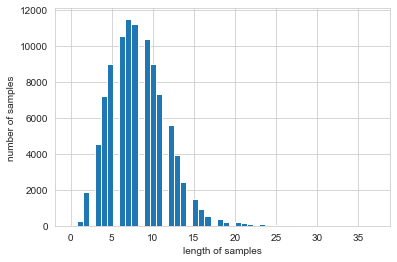

In [41]:
print('텍스트의 최대 길이 :',max(len(text) for text in train_sequences))
print('텍스트의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(text) for text in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [42]:
trunc_type = 'post'
padding_type = 'post'
MAX_LEN = 10

X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)
X_test= pad_sequences(test_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)

In [43]:
print(X_train[:5])

[[1604 6940  147  126  203   30   13  314    2  107]
 [   3  158    2    2    9  146   76  158   29    3]
 [ 113  339    7  125    0    0    0    0    0    0]
 [ 156 3357    2  368  320    0    0    0    0    0]
 [  50  510  339    7    0    0    0    0    0    0]]


### Labeling

In [44]:
y_train.unique()

array(['sad', 'angry', 'happy', 'disgusting', 'neutral', 'fear',
       'surprised'], dtype=object)

In [45]:
emo_dic = {
    'angry': 0, 'sad': 1, 'fear': 2, 'disgusting': 3, 'neutral': 4, 'happy': 5, 'surprised': 6
}

In [46]:
y_train = y_train.replace(emo_dic)
y_test = y_test.replace(emo_dic)
y_train.unique()

array([1, 0, 5, 3, 4, 2, 6])

## Model definition

In [47]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, mask_zero=True, input_length=MAX_LEN))
model.add(Dropout(DROP_OUT))
model.add(Conv1D(NUM_FILTERS, KERNEL_SIZE, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(HIDDEN_UNITS, activation='relu'))
model.add(Dropout(DROP_OUT))
model.add(Dense(OUTPUT, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Model

In [48]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, callbacks=[es, mc], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT
)

Epoch 1/30
  1/175 [..............................] - ETA: 1:07 - loss: 1.9586 - accuracy: 0.0918

2022-07-14 14:23:10.947612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


175/175 [==============================] - ETA: 0s - loss: 1.2505 - accuracy: 0.5031

2022-07-14 14:23:19.449662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.63866, saving model to best_model.h5
175/175 [==============================] - 9s 50ms/step - loss: 1.2505 - accuracy: 0.5031 - val_loss: 0.9596 - val_accuracy: 0.6387
Epoch 2/30
174/175 [============================>.] - ETA: 0s - loss: 0.8660 - accuracy: 0.6737
Epoch 2: val_accuracy improved from 0.63866 to 0.67259, saving model to best_model.h5
175/175 [==============================] - 9s 49ms/step - loss: 0.8659 - accuracy: 0.6738 - val_loss: 0.8576 - val_accuracy: 0.6726
Epoch 3/30
175/175 [==============================] - ETA: 0s - loss: 0.7625 - accuracy: 0.7122
Epoch 3: val_accuracy improved from 0.67259 to 0.67330, saving model to best_model.h5
175/175 [==============================] - 8s 47ms/step - loss: 0.7625 - accuracy: 0.7122 - val_loss: 0.8432 - val_accuracy: 0.6733
Epoch 4/30
174/175 [============================>.] - ETA: 0s - loss: 0.6978 - accuracy: 0.7370
Epoch 4: val_accuracy did not improve from 0.67330
175/175 [

## Test Model

In [49]:
loaded_model = load_model('best_model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

 15/774 [..............................] - ETA: 5s - loss: 0.8842 - accuracy: 0.6604

2022-07-14 14:24:56.536475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


774/774 [==============================] - 5s 7ms/step - loss: 0.8285 - accuracy: 0.6776
Test loss: 0.8285086154937744
Test accuracy: 0.6776005029678345


### Visualization

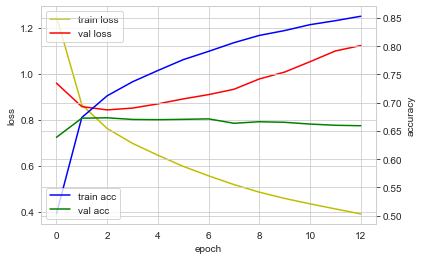

In [50]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Save Model

In [51]:
model_name = 'trained_model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/inseoklee/Desktop/miso/model/TEST_okt/trained_model.h5 


## Evaluation

### confusion matrix

In [52]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

 38/774 [>.............................] - ETA: 3s

2022-07-14 14:25:01.886496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


774/774 [==============================] - 4s 5ms/step
[0 1 1 ... 3 2 1]


[[4977 1930  122  108   65  522   11]
 [1332 6584  143   82   73  700   11]
 [ 161  215  847   12   14   73   34]
 [ 119  142   13  774   17   40   11]
 [ 101  156   24   11  482   56    2]
 [ 547  891   61   29   37 2885    2]
 [  11   27   30   24    9   13  225]]


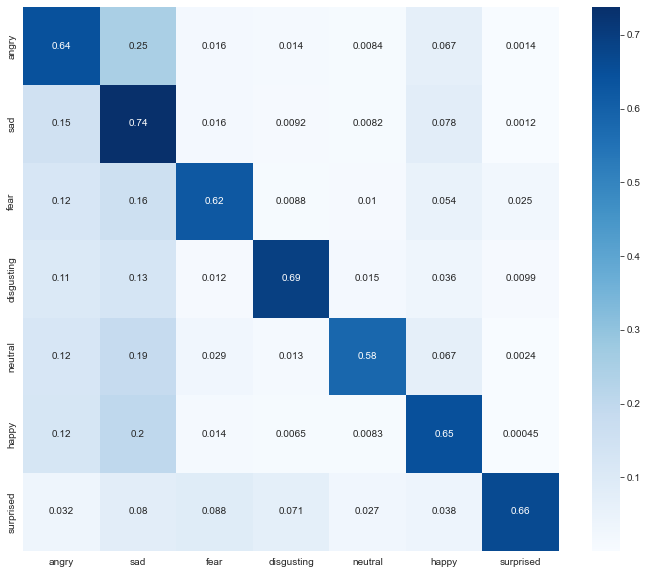

In [53]:
# constant for classes
classes = ('angry', 'sad', 'fear', 'disgusting', 'neutral', 'happy', 'surprised')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(7, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + '/output.png')

### precision, recall, f1 score

In [54]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score)

accuracy_score:  0.6776004847505555
precision_score:  0.7000471358442352
recall_score:  0.655769821188103
f1_score:  0.6759950324818839


## Load Model

In [55]:
def load_tokenizer(path):
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer

model_name = 'trained_model.h5'
tokenizer_name = 'tokenizer.pickle'
model_path = os.path.join(LOAD_DIR, model_name)
tokenizer_path = os.path.join(LOAD_DIR, tokenizer_name)

model = load_model(model_path)
tokenizer = load_tokenizer(tokenizer_path)


In [56]:
def getResult(predict) :
    highest = 0
    highestIdx = 0
    for x in range (0,len(predict)) :
        if(predict[x] > highest) :
            highestIdx = x
            highest =predict[x]
    return highestIdx

def predict_sentiment(text, model):
    tokens = []
    if type(text) == str:
        tokens.append(preprocessing(text, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        tokens.append([]) #string이 아니면 비어있는 값 추가
    token_sequences = tokenizer.texts_to_sequences(tokens)
    if(len(token_sequences) == 0) :
        return "너무 짧아"
    padded_sequences = pad_sequences(token_sequences, maxlen=MAX_LEN)
    predict = model.predict(padded_sequences)
    print(predict)
    result = getResult(predict[0])
    if result == 0 :
        return 'angry'
    elif result == 1 :
        return 'sad'
    elif result == 2 :
        return 'fear'
    elif result == 3 :
        return 'disgusting'
    elif result == 4 :
        return 'neutral'
    elif result == 5 :
        return 'happy'
    elif result == 6 :
        return 'surprised'

In [57]:
predict_sentiment("너 엄마가 일찍 들어오라고 했어 안했어.", model)

NameError: name 'stop_words' is not defined

In [ ]:
predict_sentiment("친구가 다쳐서 병문안 가야돼.", model)